In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm, trange

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 64, 3, 2, padding=1)  # B x 64 x 64 x 64
        self.bn1 = nn.BatchNorm2d(64)
        self.lru1 = nn.LeakyReLU(1e-2)

        self.c2 = nn.Conv2d(64, 128, 3, 2, padding=1)  # B x 128 x 32 x 32
        self.bn2 = nn.BatchNorm2d(128)
        self.lru2 = nn.LeakyReLU(1e-2)

        self.c3 = nn.Conv2d(128, 128, 3, 2, padding=1)  # B x 128 x 16 x 16
        self.bn3 = nn.BatchNorm2d(128)
        self.lru3 = nn.LeakyReLU(1e-2)

        self.c4 = nn.Conv2d(128, 128, 3, 2, padding=1)  # B x 128 x 8 x 8
        self.bn4 = nn.BatchNorm2d(128)
        self.lru4 = nn.LeakyReLU(1e-2)

        self.c5 = nn.Conv2d(128, 128, 3, 2, padding=1)  # B x 128 x 4 x 4
        self.bn5 = nn.BatchNorm2d(128)
        self.lru5 = nn.LeakyReLU(1e-2)

        self.c6 = nn.Conv2d(128, 128, 3, 2, padding=1)  # B x 128 x 2 x 2
        self.bn6 = nn.BatchNorm2d(128)
        self.lru6 = nn.LeakyReLU(1e-2)

        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=-1)
        self.z_mu = nn.Linear(128 * 2 * 2, 200)
        self.z_logvar = nn.Linear(128 * 2 * 2, 200)

    def forward(self, x):
        x = self.lru1(self.bn1(self.c1(x)))
        x = self.lru2(self.bn2(self.c2(x)))
        x = self.lru3(self.bn3(self.c3(x)))
        x = self.lru4(self.bn4(self.c4(x)))
        x = self.lru5(self.bn5(self.c5(x)))
        x = self.lru6(self.bn6(self.c6(x)))

        x = self.flatten_layer(x)
        z_mu = self.z_mu(x)
        z_logvar = self.z_logvar(x)

        return z_mu, z_logvar

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(200, 128 * 2 * 2)  # Match the latent space size

        self.deconv1 = nn.ConvTranspose2d(128, 128, 3, 2, padding=1, output_padding=1)  # B x 128 x 4 x 4
        self.bn1 = nn.BatchNorm2d(128)
        self.lru1 = nn.LeakyReLU(1e-2)

        self.deconv2 = nn.ConvTranspose2d(128, 128, 3, 2, padding=1, output_padding=1)  # B x 128 x 8 x 8
        self.bn2 = nn.BatchNorm2d(128)
        self.lru2 = nn.LeakyReLU(1e-2)

        self.deconv3 = nn.ConvTranspose2d(128, 128, 3, 2, padding=1, output_padding=1)  # B x 128 x 16 x 16
        self.bn3 = nn.BatchNorm2d(128)
        self.lru3 = nn.LeakyReLU(1e-2)

        self.deconv4 = nn.ConvTranspose2d(128, 128, 3, 2, padding=1, output_padding=1)  # B x 128 x 32 x 32
        self.bn4 = nn.BatchNorm2d(128)
        self.lru4 = nn.LeakyReLU(1e-2)

        self.deconv5 = nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1)  # B x 64 x 64 x 64
        self.bn5 = nn.BatchNorm2d(64)
        self.lru5 = nn.LeakyReLU(1e-2)

        self.deconv6 = nn.ConvTranspose2d(64, 3, 3, 2, padding=1, output_padding=1)  # B x 3 x 128 x 128
        self.output_activation = nn.Sigmoid()

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 2, 2)

        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.lru1(x)

        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.lru2(x)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.lru3(x)

        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.lru4(x)

        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.lru5(x)

        x = self.deconv6(x)
        x = self.output_activation(x)

        return x

In [5]:
class Sampling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,z_mean,z_logvar):
        batch_size,dim = z_mean.shape
        epsilon = torch.randn(batch_size,dim,device=z_mean.device)
        return z_mean + torch.exp(0.5*z_logvar)*epsilon

In [6]:
def KL_Divergence_Loss(z_mean,z_logvar):
    loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    loss = loss.mean()
    return loss

criterion = nn.MSELoss(reduction='sum')

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal Performance Shaders) backend")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA backend")
else:
    device = torch.device("cpu")
    print("MPS backend not available, falling back to CPU")

Using MPS (Apple Metal Performance Shaders) backend


In [8]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
sampling_layer = Sampling().to(device)

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling_layer = sampling_layer

    def forward(self,x):
        z_mean,z_logvar = self.encoder(x)
        loss = KL_Divergence_Loss(z_mean,z_logvar)
        z_sample = self.sampling_layer(z_mean,z_logvar)
        out = self.decoder(z_sample)
        return loss,out

model = AutoEncoder().to(device)

if hasattr(torch, 'compile'):
    model = torch.compile(model)

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01,weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1,threshold=0.001)

In [10]:
epochs = 10

beta = 1.0

val_losses = []

In [11]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['filepath']
        age = self.data_frame.iloc[idx]['age']
        gender = self.data_frame.iloc[idx]['gender']

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.tensor([age, gender], dtype=torch.float32)

        return image, label

In [15]:
batch_size = 64

train_csv = "Dataset/Index/Train.csv"
val_csv = "Dataset/Index/Validation.csv"
test_csv = "Dataset/Index/Test.csv"

train_dataset = ImageDataset(train_csv, transform=image_transforms)
val_dataset = ImageDataset(val_csv, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

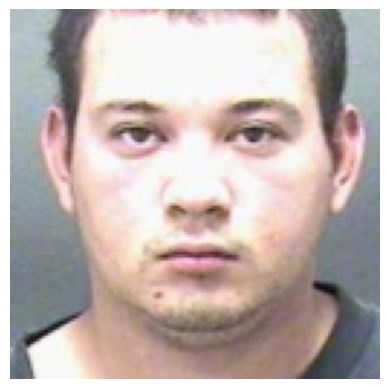

In [16]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_loader))

sample_image, _ = sample_batch

sample_image = sample_image[0].cpu().numpy().transpose(1, 2, 0)

sample_image = (sample_image * 0.5) + 0.5

plt.imshow(sample_image)
plt.axis("off")
plt.show()

In [17]:
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

In [ ]:
for epoch in trange(epochs, desc="Epoch Progress", position=0, leave=True):
    model.train()
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0
    num_batches = len(train_loader)

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}", position=1, leave=False, dynamic_ncols=True) as pbar:
        for xb, yb in pbar:
            optimizer.zero_grad(set_to_none=True)

            xb = xb.to(device, non_blocking=True)

            kl_loss, outs = model(xb)
            outs = outs.to(device)

            reconstructed_loss = criterion(xb, outs)
            reconstructed_loss = reconstructed_loss/batch_size

            total_kl_loss += kl_loss.item()
            total_rec_loss += reconstructed_loss.item()

            loss = reconstructed_loss + beta * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    torch.backends.mps.synchronize()

    avg_train_loss = total_loss / num_batches
    avg_rec_loss = total_rec_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", position=2, leave=False, dynamic_ncols=True) as pbar:
            for xb, yb in pbar:
                xb = xb.to(device)
                kl_loss, outs = model(xb)
                outs = outs.to(device)

                reconstructed_loss = criterion(xb, outs) / batch_size
                val_loss = reconstructed_loss + beta * kl_loss
                total_val_loss += val_loss.item()

                pbar.set_postfix({"Val Loss": val_loss.item()})

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_filename)

    scheduler.step(avg_val_loss)

In [ ]:
model.eval()
zsample = torch.randn(1, 200).to(device)
with torch.no_grad():
    gen_img = decoder(zsample)
    gen_img = gen_img.cpu().detach().numpy().squeeze(0)
    gen_img = gen_img.transpose(1, 2, 0)
    plt.imshow(gen_img)
    plt.axis('off')  # Turn off axis labels
    plt.show()